# Perform optimal Fock state generation in superconducting resonators
**Engineering fast cavity state generation in superconducting cavity-qubit systems**

Boulder Opal provides a flexible [toolkit for control optimization](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs) in high-dimensional and complex Hilbert spaces. Superconducting cavity-qubit systems exhibit a variety of interaction terms and rates, such that analytical schemes typically isolate target transitions or regimes to simplify the dynamics. This complexity, however, can be a resource for optimized control schemes that can exploit the interplay of interactions and coupling rates to perform faster or higher-fidelity operations.

In this application note, we demonstrate the flexibility of Boulder Opal optimization tools to directly generate and validate Fock state preparation schemes that fully leverage your available controls, without inducing leakage to higher cavity or transmon levels. This direct Fock state generation is complementary to the approach of [optimizing SNAP gates demonstrated in our application note](https://docs.q-ctrl.com/boulder-opal/application-notes/designing-fast-optimal-snap-gates-in-superconducting-resonators). Here, we will cover Fock state generation with different control freedoms:
* Optimizing both a transmon and a cavity drive in the dispersive regime,
* Optimizing a transmon drive and tunable transmon frequency to exploit resonant qubit-cavity interactions,
* Validating the optimized scheme performance using simulation.

Ultimately, we demonstrate how model-based numeric optimization provides a means to dramatically enhance gate speed without performance degradation in qubit-oscillator systems.

## Imports and initialization

In [1]:
import numpy as np
import jsonpickle
import matplotlib.pyplot as plt
import qctrlvisualizer as qv

import boulderopal as bo

# Plotting style.
plt.style.use(qv.get_qctrl_style())


# Read and write helper functions, type independent.
def save_variable(file_name, var):
    """
    Save a single variable to a file using jsonpickle.
    """
    with open(file_name, "w+") as file:
        file.write(jsonpickle.encode(var))


def load_variable(file_name):
    """
    Load a variable from a file encoded with jsonpickle.
    """
    with open(file_name, "r+") as file:
        return jsonpickle.decode(file.read())


# Flag to read long optimization results from files.
use_saved_data = True

## Generate a Fock state in the dispersive regime

The system consists of a superconducting transmon system coupled to a cavity in the dispersive limit, as given by the following Hamiltonian:

$$H_0 = \omega_C a^\dagger a + \frac{K}{2} (a^\dagger)^2 a^2 + \omega_T b^\dagger b + \frac{\alpha}{2} (b^\dagger)^2 b^2 + \chi a^\dagger a b^\dagger b, $$

where $\omega_C$ is the cavity transition frequency, $a$ is the annihilation operator of a cavity excitation, $b$ is the annihilation operator of the transmon system, $K$ is the Kerr coefficient, $\omega_T$ is the transmon frequency, $\alpha$ is the transmon nonlinearity, and $\chi$ is the dispersive shift. Consider drives applied to both the transmon and the cavity with frequencies $\nu_T$ and $\omega_C$, respectively. Then the Hamiltonian in the interaction picture with respect to $\nu_T b^\dagger b + \omega_C a^\dagger a$ becomes:

$$H = \delta b^\dagger b + \frac{K}{2} (a^\dagger)^2 a^2 + \frac{\alpha}{2} (b^\dagger)^2 b^2 + \chi a^\dagger a b^\dagger b + \left(\gamma_T (t) b + H.c.\right) + \left(\gamma_C (t) a + H.c.\right), $$

where $\delta = \omega_T - \nu_T$, and $\gamma_{T(C)}(t)= I_{T(C)}(t) + i Q_{T(C)}(t)$ is the complex drive amplitude on the transmon qubit (cavity). The basis states in the Hilbert space will be denoted by $|i,j\rangle =|i\rangle_T \otimes |j\rangle_C$, for the transmon number state $|i\rangle_T$ and cavity number state $|j\rangle_C$.

### Creating optimized controls

Using Boulder Opal, we apply the optimizer to obtain smooth controls that produce the target state $|0, 3\rangle$, starting from the initial ground state $|0, 0\rangle$.

First, we set the parameters for the system, the optimizer, and the target operation. Optimization variables include the truncation dimensions for the optimizer, the target `gate_duration`, and maximum drive strengths. To create a smooth pulse, as described in [this user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-add-smoothing-and-band-limits-to-optimized-controls), we also define a cutoff frequency for the sinc filter that smooths the drives before they are resampled with the specified `segment_count`. These parameters, together with the operators determining the system dynamics, are sufficient to characterize the optimization procedure.

In [2]:
# System parameters.
chi = -2 * np.pi * 2194 * 1e3  # rad.Hz
K = -2 * np.pi * 3.7 * 1e3  # rad.Hz
delta = -2.5e6  # rad.Hz
alpha = -2 * np.pi * 236 * 1e6  # rad.Hz

# Optimizer parameters.
transmon_dimension = 3  # Transmon dimensions.
cavity_dimension = 12  # Cavity dimensions.
target_cavity_state = 3
gate_duration = 550e-9  # s
max_rabi_rate_T = 2 * np.pi * 8e6  # rad.Hz  # Maximum transmon drive
max_rabi_rate_C = 2 * np.pi * 8e6  # rad.Hz  # Maximum cavity drive
optimization_variable_count = 64
segment_count = 128
sinc_cutoff_frequency = 2 * np.pi * 4e7  # rad.Hz


def create_transmon_and_cavity_operators(graph, dim_t, dim_c):
    b = graph.kron(graph.annihilation_operator(dim_t), np.eye(dim_c))
    bdag = graph.kron(graph.creation_operator(dim_t), np.eye(dim_c))
    n_t = graph.kron(graph.number_operator(dim_t), np.eye(dim_c))
    a = graph.kron(np.eye(dim_t), graph.annihilation_operator(dim_c))
    adag = graph.kron(np.eye(dim_t), graph.creation_operator(dim_c))
    n_c = graph.kron(np.eye(dim_t), graph.number_operator(dim_c))
    return b, bdag, n_t, a, adag, n_c

Next, we set up and perform the optimization procedure. In the following cell, time-dependent transmon and cavity drive controls are characterized by I and Q piecewise-constant drive variables. The smooth drives that would be applied to the experiment are produced by applying a sinc filter to the drive variables. The state overlap fidelity is obtained using the dynamics induced by these smooth drive controls. 

The infidelity is the first term of the cost function for optimization, which is minimized to provide high-performance controls. In the cell below, there is a second term in the cost from the occupation of the highest (truncated) oscillator number state during the operation to prevent leakage and truncation interference in the optimized dynamics.

In [3]:
if use_saved_data:
    result = load_variable("resources/fock_dispersive_optimization")
else:
    graph = bo.Graph()

    # Initial and target states.
    initial_state = graph.fock_state([transmon_dimension, cavity_dimension], [0, 0])
    target_state = graph.fock_state(
        [transmon_dimension, cavity_dimension], [0, target_cavity_state]
    )

    # Set up transmon drive optimization.
    drive_T_i_raw = graph.real_optimizable_pwc_signal(
        segment_count=optimization_variable_count,
        duration=gate_duration,
        maximum=max_rabi_rate_T,
        minimum=-max_rabi_rate_T,
    )
    drive_T_q_raw = graph.real_optimizable_pwc_signal(
        segment_count=optimization_variable_count,
        duration=gate_duration,
        maximum=max_rabi_rate_T,
        minimum=-max_rabi_rate_T,
    )
    drive_T_signal = graph.filter_and_resample_pwc(
        pwc=drive_T_i_raw + 1j * drive_T_q_raw,
        kernel=graph.sinc_convolution_kernel(sinc_cutoff_frequency),
        segment_count=segment_count,
        name="$\\gamma_T$",
    )

    # Set up the cavity drive.
    drive_C_i_raw = graph.real_optimizable_pwc_signal(
        segment_count=optimization_variable_count,
        duration=gate_duration,
        maximum=max_rabi_rate_C,
        minimum=-max_rabi_rate_C,
    )
    drive_C_q_raw = graph.real_optimizable_pwc_signal(
        segment_count=optimization_variable_count,
        duration=gate_duration,
        maximum=max_rabi_rate_C,
        minimum=-max_rabi_rate_C,
    )
    drive_C_signal = graph.filter_and_resample_pwc(
        pwc=drive_C_i_raw + 1j * drive_C_q_raw,
        kernel=graph.sinc_convolution_kernel(sinc_cutoff_frequency),
        segment_count=segment_count,
        name="$\\gamma_C$",
    )

    # Annihilation and creation operators for the transmon and cavity.
    b, bdag, n_t, a, adag, n_c = create_transmon_and_cavity_operators(
        graph, transmon_dimension, cavity_dimension
    )

    # Constant system Hamiltonian.
    H_constant = (
        delta * n_t
        + K / 2 * (n_c @ n_c - n_c)
        + alpha / 2 * (n_t @ n_t - n_t)
        + chi * n_t @ n_c
    )

    # Build the time-dependent system Hamiltonian terms.
    H_drive = graph.hermitian_part(drive_T_signal * bdag + drive_C_signal * adag)

    # Construct the total Hamiltonian.
    hamiltonian = H_constant + H_drive

    # Construct the state preparation cost.
    sample_times = np.linspace(
        gate_duration / segment_count, gate_duration, segment_count
    )
    unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=sample_times
    )
    states = unitaries @ initial_state[:, None]
    states = states[:, :, 0]
    infidelity = graph.state_infidelity(target_state, states[-1], name="infidelity")

    # Calculate population in the top cavity level.
    cavity_top_states = graph.reshape(
        states, (-1, transmon_dimension, cavity_dimension)
    )[:, :, -1]
    cavity_top_pops = graph.sum(graph.abs(cavity_top_states) ** 2, name="cavity_top")
    cost = infidelity + cavity_top_pops
    cost.name = "cost"

    result = bo.run_optimization(
        graph=graph,
        cost_node_name="cost",
        output_node_names=[
            "$\\gamma_T$",
            "$\\gamma_C$",
            "infidelity",
            "cost",
            "cavity_top",
        ],
        target_cost=5e-3,
        optimization_count=4,
    )

    save_variable("resources/fock_dispersive_optimization", result)

print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
print(
    "Sum over sampled top-level cavity population: "
    f"{result['output']['cavity_top']['value']:.3e}"
)

Infidelity: 2.918e-03
Sum over sampled top-level cavity population: 2.061e-03


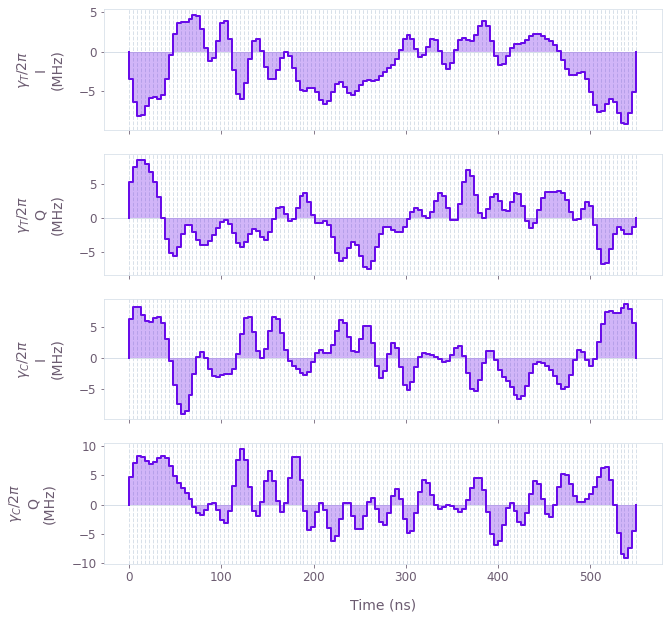

In [4]:
controls = {
    "$\\gamma_T$": result["output"]["$\\gamma_T$"],
    "$\\gamma_C$": result["output"]["$\\gamma_C$"],
}
qv.plot_controls(controls, polar=False)

The plots display the optimized drive pulses $\gamma_{T,C}(t)$ applied on the transmon qubit and the cavity, respectively.

### Simulating optimized controls to evaluate higher cavity levels
We now simulate the operation using higher dimensions of the transmon qubit and the cavity to evaluate the operation performance. This ensures that the optimization is not exploiting boundaries of the truncated space, and allows us to evaluate the infidelity including errors from leakage out of the lower-dimensional Hilbert space used for the optimization.

In [5]:
transmon_dimension = 3  # Higher transmon dimensions.
cavity_dimension = 18  # Higher cavity dimensions.

# Perform the simulation.
graph = bo.Graph()

# Initial and target states.
initial_state = graph.fock_state([transmon_dimension, cavity_dimension], [0, 0])
target_state = graph.fock_state(
    [transmon_dimension, cavity_dimension], [0, target_cavity_state]
)

# System operators defined with higher dimensions.
b, bdag, n_t, a, adag, n_c = create_transmon_and_cavity_operators(
    graph, transmon_dimension, cavity_dimension
)
H_constant = (
    delta * n_t
    + K / 2 * (n_c @ n_c - n_c)
    + alpha / 2 * (n_t @ n_t - n_t)
    + chi * n_t @ n_c
)

# Build the time-dependent system Hamiltonian terms.
drive_T_signal = graph.pwc(**result["output"]["$\\gamma_T$"])
drive_C_signal = graph.pwc(**result["output"]["$\\gamma_C$"])
H_drive = graph.hermitian_part(drive_T_signal * bdag + drive_C_signal * adag)

# Construct the total Hamiltonian.
hamiltonian = H_constant + H_drive

# Calculate states over time.
sample_times = np.linspace(0, gate_duration, int(gate_duration * 1e9) + 1)
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times
)
states = unitaries @ initial_state[:, None]
states = states[:, :, 0]
states.name = "states"

final_state = states[-1]
infidelity = graph.state_infidelity(target_state, final_state, name="infidelity")

# Calculate Wigner function of cavity state.
final_cavity_state = graph.partial_trace(
    graph.outer_product(final_state, final_state),
    [transmon_dimension, cavity_dimension],
    0,
)
position = np.linspace(-5, 5, 128)
momentum = np.linspace(-5, 5, 128)
graph.wigner_transform(final_cavity_state, position, momentum, name="wigner")

simulation = bo.execute_graph(
    graph=graph, output_node_names=["states", "infidelity", "wigner"]
)
print(f"Infidelity: {simulation['output']['infidelity']['value']:.3e}")

Your task (action_id="1829455") has started.
Your task (action_id="1829455") has completed.
Infidelity: 2.971e-03


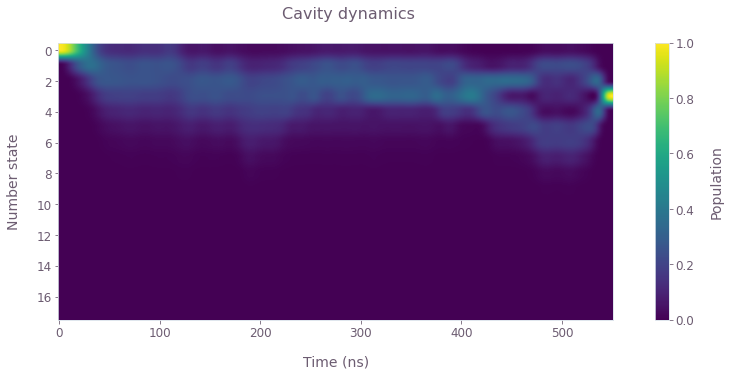

In [6]:
def plot_cavity_dynamics(states, n_t, n_c):
    cavity_pops = np.sum(np.reshape(np.abs(states) ** 2, [-1, n_t, n_c]), axis=1)
    cps = cavity_pops.shape

    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle("Cavity dynamics")
    im = ax.imshow(cavity_pops.T, aspect=0.5 * cps[0] / cps[1])
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel("Population")
    ax.set_ylabel("Number state")
    ax.set_xlabel("Time (ns)")
    plt.show()


plot_cavity_dynamics(
    simulation["output"]["states"]["value"], transmon_dimension, cavity_dimension
)

In the above plot of the cavity number-state dynamics, observe the population converging to the target state $|0,3\rangle$ by the end of the operation.

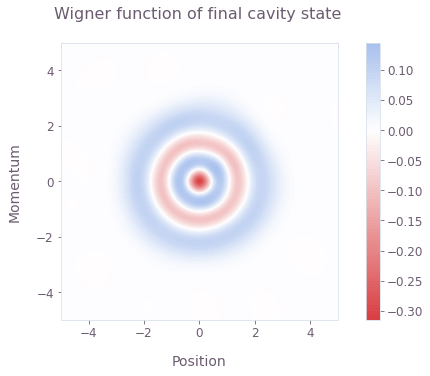

In [7]:
qv.plot_wigner_function(simulation["output"]["wigner"]["value"], position, momentum)
plt.suptitle("Wigner function of final cavity state", x=0.55)
plt.show()

The Wigner function corresponding to the final state of the cavity displays the expected distribution for a pure Fock state.

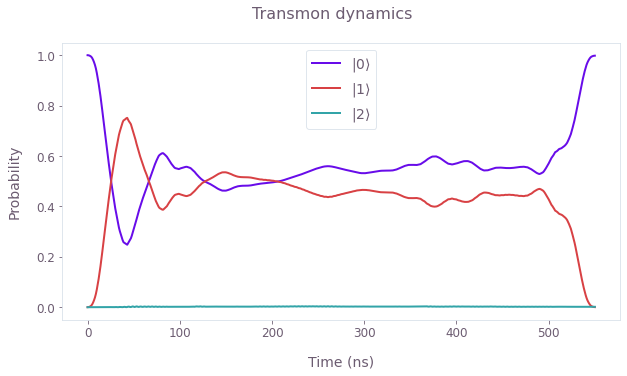

In [8]:
def plot_transmon_dynamics(times, states, n_t, n_c):
    transmon_pops = np.sum(np.reshape(np.abs(states) ** 2, [-1, n_t, n_c]), axis=2)

    qv.plot_population_dynamics(
        times, {rf"$|{k}\rangle$": transmon_pops[:, k] for k in range(n_t)}
    )
    plt.suptitle("Transmon dynamics")


plot_transmon_dynamics(
    sample_times,
    simulation["output"]["states"]["value"],
    transmon_dimension,
    cavity_dimension,
)

The above plot displays the transmon number-state population dynamics, and for the given drives only the lowest two transmon levels are substantially occupied during the operation.

## Generate a Fock state using a tunable transmon

In contrast to the above section in the dispersive regime, here we generate a Fock state by tuning the qubit frequency in and out of resonance with the cavity resonator. The dynamics in this case is described by the following Hamiltonian, rotated into the frame of the transmon drive frequency $\nu_T$:

$$H = \delta_T (t) b^\dagger b + \delta_C a^\dagger a + \frac{K}{2} (a^\dagger)^2 a^2 + \frac{\alpha}{2} (b^\dagger)^2 b^2 + \left(\frac{\Omega}{2} a b^\dagger + \gamma_T (t) b + H.c. \right) $$

such that $\delta_T (t) = \omega_T (t) - \nu_T$, $\delta_C = \omega_C - \nu_T$, and $\Omega$ is the strength of the qubit-resonator interaction. Here we exploit the tunable transmon qubit frequency and drive to prepare the Fock state; a cavity drive could similarly be added for additional control freedom.

In this section we prepare a target state $|0, 3\rangle$, starting from the initial ground state $|0, 0\rangle$. First, we optimize and validate a state preparation scheme with a fixed drive frequency that is off resonance with the resonator as in [Hofheinz et al.](https://www.nature.com/articles/nature07136). Then, we add another control to leverage the complex interactions in the system: we optimize the (static) drive frequency in addition to the drive modulation to generate and validate faster Fock state preparation.

### Creating optimized controls with an off-resonant transmon drive
In this section we apply the optimizer to obtain smooth controls that produce the target state. First, we set the parameters for drive frequency, the optimizer, and the target operation. Note that in the cell below, the transmon and cavity dimensions are set higher and lower, respectively, than in the previous optimization. This is to accomodate the variable transmon frequency and resulting higher-level transitions, along with lower cavity occupation numbers without a cavity drive.

In [9]:
omega = 2 * np.pi * 36e6  # rad.Hz
nu_T = 175 * omega  # Fixed transmon drive frequency.
delta_C = 2 * np.pi * 6.57e9 - nu_T  # Cavity detuning.
min_delta_T = 2 * np.pi * -0.05e9  # rad.Hz
max_delta_T = 2 * np.pi * 0.35e9  # rad.Hz

transmon_dimension = 4  # Transmon dimensions.
cavity_dimension = 6  # Cavity dimensions.
gate_duration = 128e-9  # s
max_rabi_rate_T = 2 * np.pi * 12e6  # rad.Hz
optimization_variable_count = 64
segment_count = 128
sinc_cutoff_frequency = 2 * np.pi * 20e7  # rad.Hz

As before, we now perform the optimization procedure. In the following cell, the time-dependent transmon qubit frequency is characterized and filtered, in addition to the transmon drive. Unlike the optimization above, the oscillator truncation term is omitted from the cost as it is usually not necessary in this case without a cavity drive.

In [10]:
if use_saved_data:
    result = load_variable("resources/fock_tunable_transmon")
else:
    graph = bo.Graph()

    # Initial and target states.
    initial_state = graph.fock_state([transmon_dimension, cavity_dimension], [0, 0])
    target_state = graph.fock_state(
        [transmon_dimension, cavity_dimension], [0, target_cavity_state]
    )

    # Set up qubit detuning variable.
    delta_T_raw = graph.real_optimizable_pwc_signal(
        segment_count=optimization_variable_count,
        duration=gate_duration,
        maximum=max_delta_T,
        minimum=min_delta_T,
    )
    delta_T_signal = graph.filter_and_resample_pwc(
        pwc=delta_T_raw,
        kernel=graph.sinc_convolution_kernel(sinc_cutoff_frequency),
        segment_count=segment_count,
        name="$\\delta_T$",
    )

    # Set up transmon drive.
    drive_T_i_raw = graph.real_optimizable_pwc_signal(
        segment_count=optimization_variable_count,
        duration=gate_duration,
        maximum=max_rabi_rate_T,
        minimum=-max_rabi_rate_T,
    )
    drive_T_q_raw = graph.real_optimizable_pwc_signal(
        segment_count=optimization_variable_count,
        duration=gate_duration,
        maximum=max_rabi_rate_T,
        minimum=-max_rabi_rate_T,
    )
    drive_T_signal = graph.filter_and_resample_pwc(
        pwc=drive_T_i_raw + 1j * drive_T_q_raw,
        kernel=graph.sinc_convolution_kernel(sinc_cutoff_frequency),
        segment_count=segment_count,
        name="$\\gamma_T$",
    )

    # Specify system operators.
    b, bdag, n_t, a, adag, n_c = create_transmon_and_cavity_operators(
        graph, transmon_dimension, cavity_dimension
    )
    H_constant = (
        delta_C * n_c
        + K / 2 * (n_c @ n_c - n_c)
        + alpha / 2 * (n_t @ n_t - n_t)
        + omega / 2 * (bdag @ a + b @ adag)
    )

    # Construct the Hamiltonian.
    H_drive = graph.hermitian_part(drive_T_signal * bdag)
    H_detuning = delta_T_signal * n_t
    hamiltonian = H_constant + H_drive + H_detuning

    # Set up the state preparation cost.
    unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=np.array([gate_duration])
    )
    states = unitaries @ initial_state[:, None]
    states = states[:, :, 0]
    infidelity = graph.state_infidelity(target_state, states[-1], name="infidelity")

    result = bo.run_optimization(
        graph=graph,
        cost_node_name="infidelity",
        output_node_names=["$\\gamma_T$", "$\\delta_T$", "infidelity"],
        optimization_count=5,
    )
    save_variable("resources/fock_tunable_transmon", result)

print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")

Infidelity: 8.468e-05


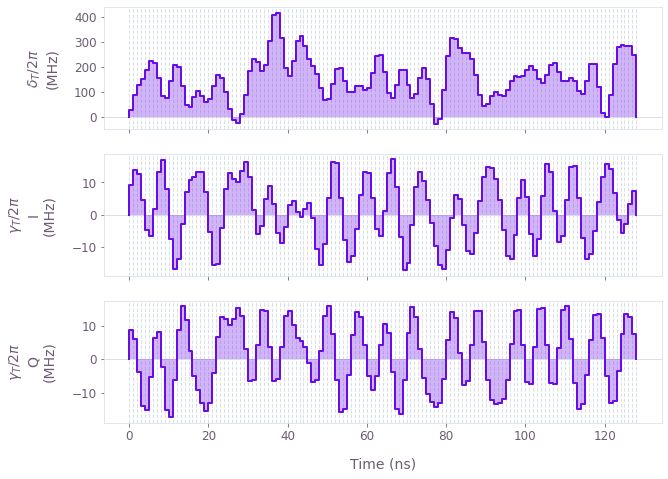

In [11]:
controls = {
    "$\\delta_T$": result["output"]["$\\delta_T$"],
    "$\\gamma_T$": result["output"]["$\\gamma_T$"],
}
qv.plot_controls(controls, polar=False)

The plots display the transmon detuning from the drive frequency $\delta_T(t)$, as well as the optimized transmon drive $\gamma_{T}(t)$.

### Simulating optimized controls with an off-resonant transmon drive

Next we simulate the dynamics of the optimized controls using additional transmon and cavity levels. This is to verify the control performance and examine the population dynamics during the operation.

In [12]:
transmon_dimension = 5  # Higher transmon dimensions.
cavity_dimension = 9  # Higher cavity dimensions.

# Perform the simulation.
graph = bo.Graph()

# Initial and target states.
initial_state = graph.fock_state([transmon_dimension, cavity_dimension], [0, 0])
target_state = graph.fock_state(
    [transmon_dimension, cavity_dimension], [0, target_cavity_state]
)

# System operators defined with higher dimensions.
b, bdag, n_t, a, adag, n_c = create_transmon_and_cavity_operators(
    graph, transmon_dimension, cavity_dimension
)
H_constant = (
    delta_C * n_c
    + K / 2 * (n_c @ n_c - n_c)
    + alpha / 2 * (n_t @ n_t - n_t)
    + omega / 2 * (bdag @ a + b @ adag)
)

# Build the time-dependent system Hamiltonian terms.
drive_T_signal = graph.pwc(**result["output"]["$\\gamma_T$"])
delta_T_signal = graph.pwc(**result["output"]["$\\delta_T$"])
H_drive = graph.hermitian_part(drive_T_signal * bdag)
H_detuning = delta_T_signal * n_t

# Construct the total Hamiltonian.
hamiltonian = H_constant + H_drive + H_detuning

# Calculate states over time.
sample_times = np.linspace(0, gate_duration, int(gate_duration * 1e9) + 1)
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times
)
states = unitaries @ initial_state[:, None]
states = states[:, :, 0]
states.name = "states"

final_state = states[-1]
infidelity = graph.state_infidelity(target_state, final_state, name="infidelity")

# Calculate Wigner function of cavity state.
final_cavity_state = graph.partial_trace(
    graph.outer_product(final_state, final_state),
    [transmon_dimension, cavity_dimension],
    0,
)
position = np.linspace(-5, 5, 128)
momentum = np.linspace(-5, 5, 128)
graph.wigner_transform(final_cavity_state, position, momentum, name="wigner")

simulation = bo.execute_graph(
    graph=graph, output_node_names=["states", "infidelity", "wigner"]
)
print(f"Infidelity: {simulation['output']['infidelity']['value']:.3e}")

Your task (action_id="1829459") has started.
Your task (action_id="1829459") has completed.
Infidelity: 9.041e-05


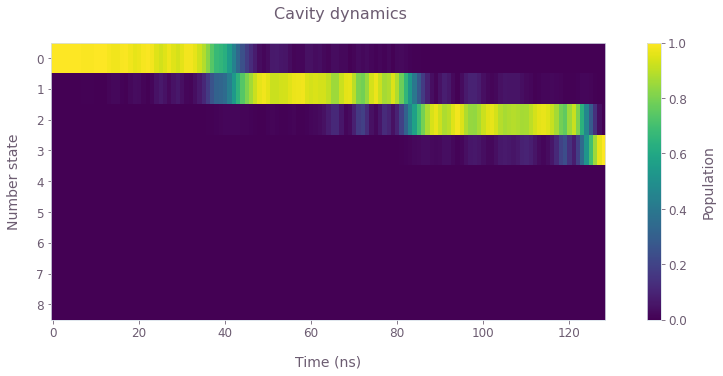

In [13]:
plot_cavity_dynamics(
    simulation["output"]["states"]["value"], transmon_dimension, cavity_dimension
)

In the above plot of the cavity number-state dynamics, observe the population converging to the target state $|0,3\rangle$ by the end of the operation. The population seems to increase in steps using the optimized controls.

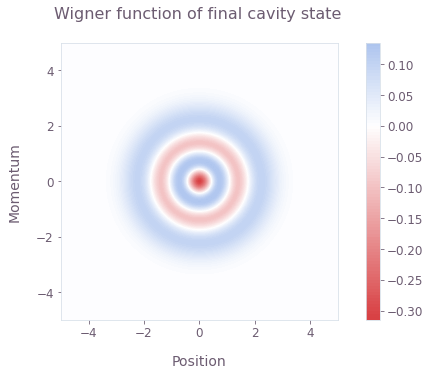

In [14]:
qv.plot_wigner_function(simulation["output"]["wigner"]["value"], position, momentum)
plt.suptitle("Wigner function of final cavity state", x=0.55)
plt.show()

Again, the final cavity Wigner function matches that of a pure Fock state.

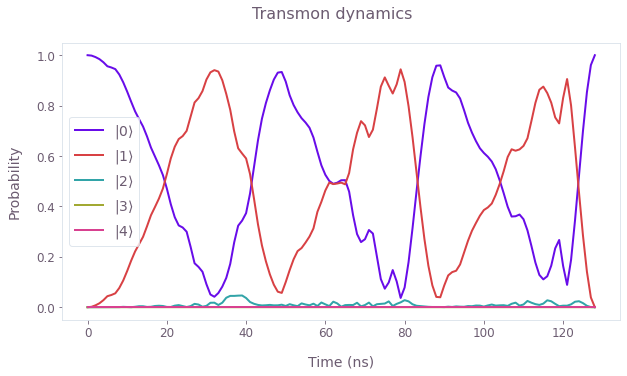

In [15]:
plot_transmon_dynamics(
    sample_times,
    simulation["output"]["states"]["value"],
    transmon_dimension,
    cavity_dimension,
)

In the above plot of the transmon number-state dynamics, the population oscillates between the $|0\rangle$ and $|1\rangle$ number states. This is correlated with the cavity dynamics above: the transmon excitation is induced by the drive away from the resonant interaction regime with the cavity, and the cavity population can subsequently increase when the transmon is tuned into the resonant regime. These dynamics are expected with the available controls, and are similar to those displayed by the analytical Fock state generation scheme in [Hofheinz et al.](https://www.nature.com/articles/nature07136). In the next section, we add another control degree of freedom to allow more flexible and faster operation dynamics.

### Creating optimized controls with an optimized-frequency transmon drive

Here we add an extra degree of control over the Fock state generation scheme by optimizing the frequency of the transmon drive. Again, the drive frequency is fixed, and this could optionally be made dynamic for additional control. As before, we specify the system and optimization parameters before optimizing the controls.

In [16]:
transmon_dimension = 4  # Transmon dimensions.
cavity_dimension = 6  # Cavity dimensions.
gate_duration = 100e-9  # s
max_rabi_rate_T = 2 * np.pi * 12e6  # rad.Hz
min_nu_T = 2 * np.pi * 6.25e9  # rad.Hz
max_nu_T = 2 * np.pi * 6.57e9  # rad.Hz
min_delta_T = 2 * np.pi * -0.05e9  # rad.Hz
max_delta_T = 2 * np.pi * 0.35e9  # rad.Hz
optimization_variable_count = 64
segment_count = 128
sinc_cutoff_frequency = 2 * np.pi * 20e7  # rad.Hz

In [17]:
if use_saved_data:
    result = load_variable("resources/fock_optimized_frequency")
else:
    graph = bo.Graph()

    # Initial and target states.
    initial_state = graph.fock_state([transmon_dimension, cavity_dimension], [0, 0])
    target_state = graph.fock_state(
        [transmon_dimension, cavity_dimension], [0, target_cavity_state]
    )

    # Set up drive frequency optimization.
    nu_T = graph.optimizable_scalar(lower_bound=min_nu_T, upper_bound=max_nu_T)

    # Define cavity detuning from the drive frequency.
    delta_C = 2 * np.pi * 6.57e9 - nu_T
    delta_C.name = "$\\delta_C$"

    # Set up transmon frequency optimization.
    delta_T_raw = graph.real_optimizable_pwc_signal(
        segment_count=optimization_variable_count,
        duration=gate_duration,
        maximum=max_delta_T,
        minimum=min_delta_T,
    )
    delta_T_signal = graph.filter_and_resample_pwc(
        pwc=delta_T_raw,
        kernel=graph.sinc_convolution_kernel(sinc_cutoff_frequency),
        segment_count=segment_count,
        name="$\\delta_T$",
    )

    # Set up transmon drive optimization.
    drive_T_i_raw = graph.real_optimizable_pwc_signal(
        segment_count=optimization_variable_count,
        duration=gate_duration,
        maximum=max_rabi_rate_T,
        minimum=-max_rabi_rate_T,
    )
    drive_T_q_raw = graph.real_optimizable_pwc_signal(
        segment_count=optimization_variable_count,
        duration=gate_duration,
        maximum=max_rabi_rate_T,
        minimum=-max_rabi_rate_T,
    )
    drive_T_signal = graph.filter_and_resample_pwc(
        pwc=drive_T_i_raw + 1j * drive_T_q_raw,
        kernel=graph.sinc_convolution_kernel(sinc_cutoff_frequency),
        segment_count=segment_count,
        name="$\\gamma_T$",
    )

    # Set up system operators.
    b, bdag, n_t, a, adag, n_c = create_transmon_and_cavity_operators(
        graph, transmon_dimension, cavity_dimension
    )
    H_constant = (
        K / 2 * (n_c @ n_c - n_c)
        + alpha / 2 * (n_t @ n_t - n_t)
        + omega / 2 * (bdag @ a + b @ adag)
    )

    # Construct the Hamiltonian.
    H_drive = graph.hermitian_part(drive_T_signal * bdag)
    H_detuning = delta_T_signal * n_t + delta_C * n_c
    hamiltonian = H_constant + H_drive + H_detuning

    # Construct the state preparation cost.
    unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=np.array([gate_duration])
    )
    states = unitaries @ initial_state[:, None]
    states = states[:, :, 0]
    infidelity = graph.state_infidelity(target_state, states[-1], name="infidelity")

    result = bo.run_optimization(
        graph=graph,
        cost_node_name="infidelity",
        output_node_names=["$\\gamma_T$", "$\\delta_T$", "$\\delta_C$", "infidelity"],
        optimization_count=6,
    )
    save_variable("resources/fock_optimized_frequency", result)

print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")

Infidelity: 1.725e-05


Cavity detuning from drive: 0.01884 GHz


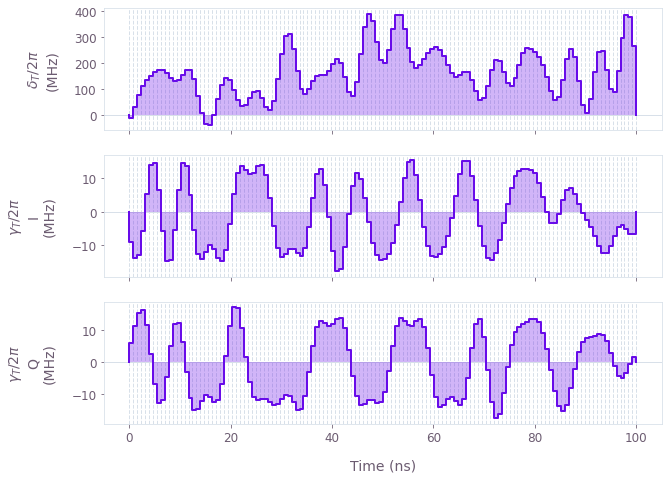

In [18]:
optimized_delta_C = result["output"]["$\\delta_C$"]["value"]
print(f"Cavity detuning from drive: {optimized_delta_C  / (2 * np.pi * 1e9):.5f} GHz")
controls = {
    "$\\delta_T$": result["output"]["$\\delta_T$"],
    "$\\gamma_T$": result["output"]["$\\gamma_T$"],
}
qv.plot_controls(controls, polar=False)

The plots display the transmon detuning from the drive frequency $\delta_T(t)$, as well as the optimized transmon drive $\gamma_{T}(t)$.

### Simulating optimized controls with an optimized-frequency transmon drive

Next we simulate the dynamics of the optimized controls using additional transmon and cavity levels. This is to verify the control performance and examine the population dynamics during the operation.

In [19]:
transmon_dimension = 5  # Higher transmon dimensions.
cavity_dimension = 9  # Higher cavity dimensions.


# Perform the simulation.
graph = bo.Graph()

# Initial and target states.
initial_state = graph.fock_state([transmon_dimension, cavity_dimension], [0, 0])
target_state = graph.fock_state(
    [transmon_dimension, cavity_dimension], [0, target_cavity_state]
)

# System operators defined with higher dimensions.
b, bdag, n_t, a, adag, n_c = create_transmon_and_cavity_operators(
    graph, transmon_dimension, cavity_dimension
)

H_constant = (
    K / 2 * (n_c @ n_c - n_c)
    + alpha / 2 * (n_t @ n_t - n_t)
    + omega / 2 * (bdag @ a + b @ adag)
)

# Build the time-dependent system Hamiltonian terms.
drive_T_signal = graph.pwc(**result["output"]["$\\gamma_T$"])
delta_T_signal = graph.pwc(**result["output"]["$\\delta_T$"])
delta_C = result["output"]["$\\delta_C$"]["value"]
H_drive = graph.hermitian_part(drive_T_signal * bdag)
H_detuning = delta_T_signal * n_t + delta_C * n_c

# Construct the total Hamiltonian.
hamiltonian = H_constant + H_drive + H_detuning

# Calculate states over time.
sample_times = np.linspace(0, gate_duration, int(gate_duration * 1e9) + 1)
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times
)
states = unitaries @ initial_state[:, None]
states = states[:, :, 0]
states.name = "states"

final_state = states[-1]
infidelity = graph.state_infidelity(target_state, final_state, name="infidelity")

# Calculate Wigner function of cavity state.
final_cavity_state = graph.partial_trace(
    graph.outer_product(final_state, final_state),
    [transmon_dimension, cavity_dimension],
    0,
)
position = np.linspace(-5, 5, 128)
momentum = np.linspace(-5, 5, 128)
graph.wigner_transform(final_cavity_state, position, momentum, name="wigner")

simulation = bo.execute_graph(
    graph=graph, output_node_names=["states", "infidelity", "wigner"]
)
print(f"Infidelity: {simulation['output']['infidelity']['value']:.3e}")

Your task (action_id="1829462") has started.
Your task (action_id="1829462") has completed.
Infidelity: 2.538e-04


The cavity number-state populations displayed in the figure exhibit faster accumulation with the optimized drive frequency. The dynamics are more complex than the step-wise increase observed for the off-resonant drive above.

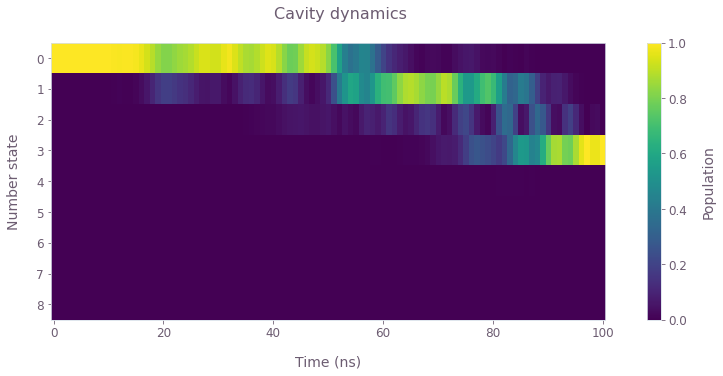

In [20]:
plot_cavity_dynamics(
    simulation["output"]["states"]["value"], transmon_dimension, cavity_dimension
)

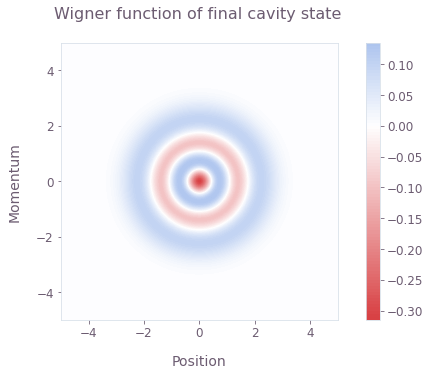

In [21]:
qv.plot_wigner_function(simulation["output"]["wigner"]["value"], position, momentum)
plt.suptitle("Wigner function of final cavity state", x=0.55)
plt.show()

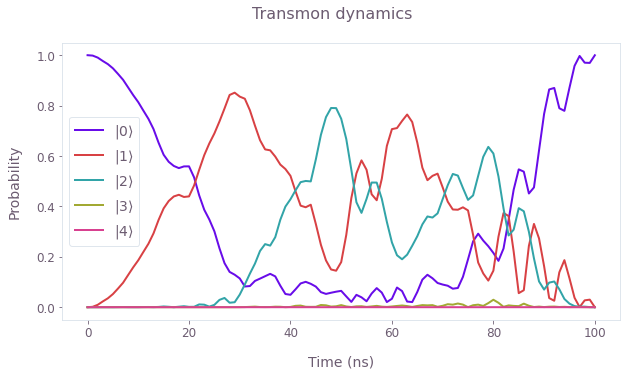

In [22]:
plot_transmon_dynamics(
    sample_times,
    simulation["output"]["states"]["value"],
    transmon_dimension,
    cavity_dimension,
)

The transmon dynamics are similarly more complex than for the off-resonant drive, and involve higher-level excitations that contribute to faster Fock state generation in the cavity. Here the optimized drive frequency permits the state generation in 100ns, in contrast to the 128ns scheme without this optimization. Boulder Opal optimization tools thus exploit the full system dynamics to generate optimal controls; further control freedoms could similarly be added to enhance the scheme speed or robustness to noise sources.